# Profiles Group
March 2019 OOI Data Labs Workshop

**Key Goals**
* Would like students to see an “ideal profile” with an Oxygen minimum zone (e.g. slide 3 from ppt)
* Also want to look at seasonal changes – how do DO and Chl co-vary seasonally (e.g. summer to winter solstices)
* Key question is where the min/max of DO and Chl are, so surface layer is probably best.
* Really interested in CO2, which limits the selection to the 3 cabled profilers, e.g. these [processed FLORT datasets](https://github.com/ooi-data-review/2018-data-workshops/tree/master/biology/examples/extras/FLORT).

In [1]:
# Notebook Setup
import requests
import os
import re
import xarray as xr
! pip install netcdf4==1.5.0
import matplotlib.pyplot as plt
import pickle as pk
import gc
import pandas as pd
!pip install cmocean
import cmocean
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

## Processing Functions

In [0]:
def request_data(reference_designator,method,stream,start_date,end_date):
  site = reference_designator[:8]
  node = reference_designator[9:14]
  instrument = reference_designator[15:]
  
  # Create the request URL
  api_base_url = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv'
  data_request_url ='/'.join((api_base_url,site,node,instrument,method,stream))

  # All of the following are optional, but you should specify a date range
  params = {
#     'beginDT':start_date,
#     'endDT':end_date,
    'format':'application/netcdf',
    'include_provenance':'true',
    'include_annotations':'true'
  }

  # Make the data request
  r = requests.get(data_request_url, params=params, auth=(API_USERNAME, API_TOKEN))
  data = r.json()
  
  # Return just the THREDDS URL
  return data['allURLs'][0] 

In [0]:
API_USERNAME = ''
API_TOKEN = ''

In [0]:
# Function to grab the list of .nc files in the specified directory
def get_dataset_list(url,bad_inst=''):
  tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
  datasets = requests.get(url).text
  urls = re.findall(r'href=[\'"]?([^\'" >]+)', datasets)
  x = re.findall(r'(ooi/.*?.nc)', datasets)
  for i in x:
    if i.endswith('.nc') == False:
      x.remove(i)
  for i in x:
    try:
      float(i[-4])
    except:
      x.remove(i)
  datasets = [os.path.join(tds_url, i) for i in x]
  
  # Remove extraneous files if necessary
  selected_datasets = []
  for d in datasets:
    if (bad_inst) and bad_inst in d:
      pass
    elif 'ENG000' in d: #Remove engineering streams for gliders
      pass
    elif '_cal_' in d: #Remove pco2 cal streams
      pass
    else:
      selected_datasets.append(d)
#   print(selected_datasets)
  return selected_datasets

In [0]:
# Function to make the output directory for the averaged pickle files
def make_dir(new_dir):
  if not os.path.isdir(new_dir):
    try:
      os.makedirs(new_dir)
    except OSError:
      if os.path.exists(new_dir):
        pass
      else:
        raise

In [0]:
def process_files(file_list,var_list,output_dir):
  make_dir(output_dir)
  # Downsample datafiles
  num = 0
  for i in file_list:
    print('Downsampling file {} of {}'.format(str(num + 1), str(len(file_list))))
    ds = xr.open_dataset(i)
    ds = ds.swap_dims({'obs': 'time'})
    dnsample = pd.DataFrame()
    for j in var_list:
      dnsample[j] = ds[j].to_pandas().resample('T').mean()
    dnsample = dnsample.dropna()
    out = output_dir + '/' + i.split('/')[-1][:-3] + '_resampled' + '.pd'
    with open(out, 'wb') as fh:
      pk.dump(dnsample,fh)
    gc.collect()
    num = num +1
  print('Complete!')
  
  # Create a single file with all the pickled CTD data
  data = pd.DataFrame()
  for path, subdirs, files in os.walk(output_dir):
    for name in files:
      file_name = os.path.join(path, name)
      with open(file_name, 'rb') as f:
        pd_df = pk.load(f)
        data = data.append(pd_df)
  with open(output_dir+'_dn', 'wb') as f:
    pk.dump(data,f)
  return data

In [0]:
import numpy as np
def reject_outliers(data, m=3):
    """
    Reject outliers beyond m standard deviations of the mean.
    :param data: numpy array containing data
    :param m: number of standard deviations from the mean. Default: 3
    """
    stdev = np.nanstd(data)
    if stdev > 0.0:
        ind = abs(data - np.nanmean(data)) < m * stdev
    else:
        ind = len(data) * [True]

    return ind

In [0]:
def make_plot(x,y,z,cmap,clabel,title):
  fig, ax = plt.subplots(1,1)
  fig.set_size_inches(10,4)
  if 'pCO2' in title:
    s = ax.scatter(x, y, c=z, marker=".", s=1, cmap=cmap, vmin=100, vmax=600)
    cbh = plt.colorbar(s,ax=ax,extend='both')
  else:
    s = ax.scatter(x, y, c=z, marker=".", s=1, cmap=cmap)
    cbh = plt.colorbar(s,ax=ax)
  cbh.set_label(clabel)
  ax.set_xlim(min(x),max(x));
  ax.invert_yaxis()
  ax.set_title(title);
  fig.autofmt_xdate()
  # ax.xaxis.set_major_locator(ticker.MultipleLocator(7))
  # ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
  plt.savefig("%s.png" % title)

## RS01SBPS Oregon Slope Base Shallow Profiler Mooring (2,906m)

In [0]:
# Data Requests
# request_data('RS01SBPS-SF01A-2A-CTDPFA102','streamed','ctdpf_sbe43_sample','','')
# request_data('RS01SBPS-SF01A-3A-FLORTD101','streamed','flort_d_data_record','','')
# request_data('RS01SBPS-SF01A-4F-PCO2WA101','streamed','pco2w_a_sami_data_record','','')

In [0]:
rs01_ctd_url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20190507T170216-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample/catalog.html'
rs01_flo_url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20190508T030403-RS01SBPS-SF01A-3A-FLORTD101-streamed-flort_d_data_record/catalog.html'
rs01_co2_url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20190508T030413-RS01SBPS-SF01A-4F-PCO2WA101-streamed-pco2w_a_sami_data_record/catalog.html'


In [11]:
# Load CTD Data
ctd_list = get_dataset_list(rs01_ctd_url)
var_list = ['practical_salinity','seawater_temperature','seawater_pressure','corrected_dissolved_oxygen']
ctd_data = process_files(ctd_list,var_list,'RS01-CTD')
# Remove outliers
ctd_data['practical_salinity2'] = ctd_data['practical_salinity'].where(reject_outliers(ctd_data['practical_salinity']))


Downsampling file 1 of 19
Downsampling file 2 of 19
Downsampling file 3 of 19
Downsampling file 4 of 19
Downsampling file 5 of 19
Downsampling file 6 of 19
Downsampling file 7 of 19
Downsampling file 8 of 19
Downsampling file 9 of 19
Downsampling file 10 of 19
Downsampling file 11 of 19
Downsampling file 12 of 19
Downsampling file 13 of 19
Downsampling file 14 of 19
Downsampling file 15 of 19
Downsampling file 16 of 19
Downsampling file 17 of 19
Downsampling file 18 of 19
Downsampling file 19 of 19
Complete!


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


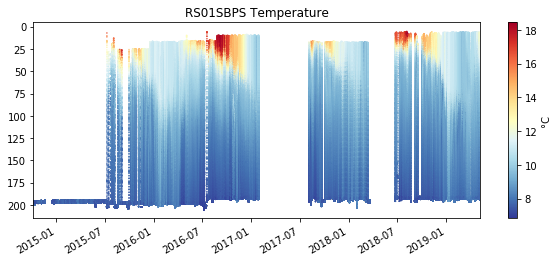

In [12]:
# Temperature
make_plot(ctd_data.index,ctd_data.seawater_pressure,ctd_data.seawater_temperature,'RdYlBu_r','°C','RS01SBPS Temperature')


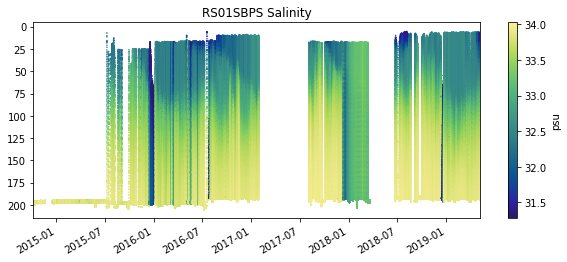

In [13]:
# Salinity
make_plot(ctd_data.index,ctd_data.seawater_pressure,ctd_data.practical_salinity2,cmocean.cm.haline,'psu','RS01SBPS Salinity')


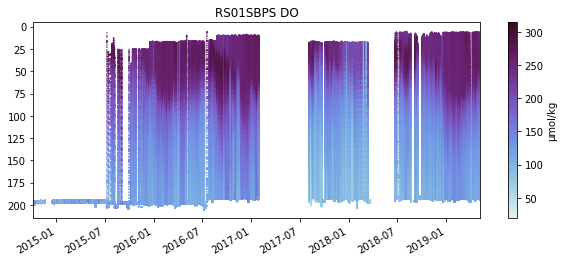

In [14]:
# DO
make_plot(ctd_data.index,ctd_data.seawater_pressure,ctd_data.corrected_dissolved_oxygen,cmocean.cm.dense,'µmol/kg','RS01SBPS DO') 


In [15]:
# Load Fluorometer Data
flo_list = get_dataset_list(rs01_flo_url,'ctdpf')
var_list = ['int_ctd_pressure','fluorometric_chlorophyll_a']
flo_data = process_files(flo_list,var_list,'RS01-FLO')
# Remove outliers
flo_data['fluorometric_chlorophyll_a2'] = flo_data['fluorometric_chlorophyll_a'].where(reject_outliers(flo_data['fluorometric_chlorophyll_a']))


Downsampling file 1 of 18
Downsampling file 2 of 18
Downsampling file 3 of 18
Downsampling file 4 of 18
Downsampling file 5 of 18
Downsampling file 6 of 18
Downsampling file 7 of 18
Downsampling file 8 of 18
Downsampling file 9 of 18
Downsampling file 10 of 18
Downsampling file 11 of 18
Downsampling file 12 of 18
Downsampling file 13 of 18
Downsampling file 14 of 18
Downsampling file 15 of 18
Downsampling file 16 of 18
Downsampling file 17 of 18
Downsampling file 18 of 18
Complete!


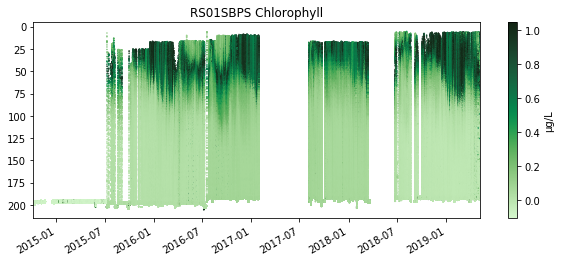

In [16]:
# Chlorophyll
make_plot(flo_data.index,flo_data.int_ctd_pressure,flo_data.fluorometric_chlorophyll_a2,cmocean.cm.algae,'µg/L','RS01SBPS Chlorophyll')


In [17]:
# Load CO2 Data
co2_list = get_dataset_list(rs01_co2_url,'ctdpf')
var_list = ['int_ctd_pressure','pco2_seawater']
co2_data = process_files(co2_list,var_list,'RS01-CO2')


Downsampling file 1 of 5
Downsampling file 2 of 5
Downsampling file 3 of 5
Downsampling file 4 of 5
Downsampling file 5 of 5
Complete!


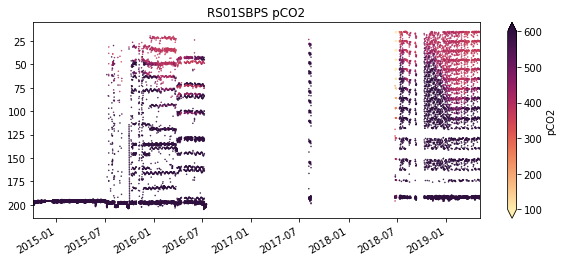

In [18]:
# pCO2
make_plot(co2_data.index,co2_data.int_ctd_pressure,co2_data.pco2_seawater,cmocean.cm.matter,'pCO2','RS01SBPS pCO2')


## RS03AXPS Axial Base Shallow Profiler Mooring	

In [0]:
# Data Requests
# request_data('RS03AXPS-SF03A-2A-CTDPFA302','streamed','ctdpf_sbe43_sample','','')
# request_data('RS03AXPS-SF03A-3A-FLORTD301','streamed','flort_d_data_record','','')
# request_data('RS03AXPS-SF03A-4F-PCO2WA301','streamed','pco2w_a_sami_data_record','','')

In [0]:
rs03_ctd_url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20190507T170227-RS03AXPS-SF03A-2A-CTDPFA302-streamed-ctdpf_sbe43_sample/catalog.html'
rs03_flo_url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20190508T030518-RS03AXPS-SF03A-3A-FLORTD301-streamed-flort_d_data_record/catalog.html'
rs03_co2_url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20190508T030526-RS03AXPS-SF03A-4F-PCO2WA301-streamed-pco2w_a_sami_data_record/catalog.html'


In [21]:
# Load CTD Data
ctd_list = get_dataset_list(rs03_ctd_url)
var_list = ['practical_salinity','seawater_temperature','seawater_pressure','corrected_dissolved_oxygen']
ctd_data = process_files(ctd_list,var_list,'RS03-CTD')
# Remove outliers
ctd_data['practical_salinity2'] = ctd_data['practical_salinity'].where(reject_outliers(ctd_data['practical_salinity']))


Downsampling file 1 of 18
Downsampling file 2 of 18
Downsampling file 3 of 18
Downsampling file 4 of 18
Downsampling file 5 of 18
Downsampling file 6 of 18
Downsampling file 7 of 18
Downsampling file 8 of 18
Downsampling file 9 of 18
Downsampling file 10 of 18
Downsampling file 11 of 18
Downsampling file 12 of 18
Downsampling file 13 of 18
Downsampling file 14 of 18
Downsampling file 15 of 18
Downsampling file 16 of 18
Downsampling file 17 of 18
Downsampling file 18 of 18
Complete!


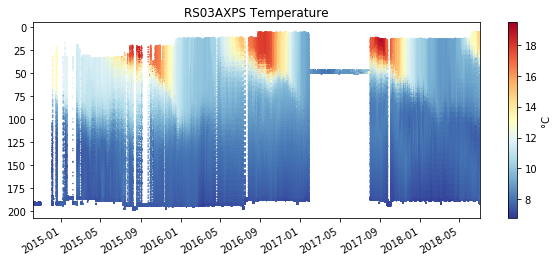

In [22]:
# Temperature
make_plot(ctd_data.index,ctd_data.seawater_pressure,ctd_data.seawater_temperature,'RdYlBu_r','°C','RS03AXPS Temperature')


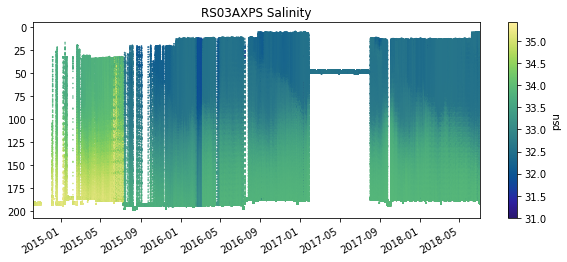

In [23]:
# Salinity
make_plot(ctd_data.index,ctd_data.seawater_pressure,ctd_data.practical_salinity2,cmocean.cm.haline,'psu','RS03AXPS Salinity')


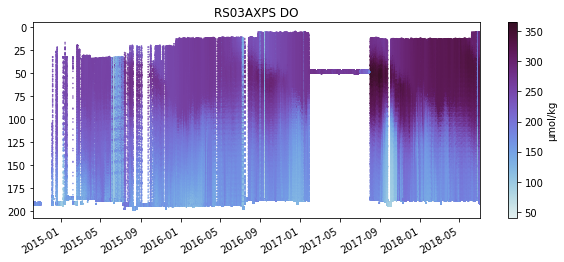

In [24]:
# DO
make_plot(ctd_data.index,ctd_data.seawater_pressure,ctd_data.corrected_dissolved_oxygen,cmocean.cm.dense,'µmol/kg','RS03AXPS DO') 


In [25]:
# Load Fluorometer Data
flo_list = get_dataset_list(rs03_flo_url,'ctdpf')
var_list = ['int_ctd_pressure','fluorometric_chlorophyll_a']
flo_data = process_files(flo_list,var_list,'RS03-FLO')
# Remove outliers
flo_data['fluorometric_chlorophyll_a2'] = flo_data['fluorometric_chlorophyll_a'].where(reject_outliers(flo_data['fluorometric_chlorophyll_a']))


Downsampling file 1 of 18
Downsampling file 2 of 18
Downsampling file 3 of 18
Downsampling file 4 of 18
Downsampling file 5 of 18
Downsampling file 6 of 18
Downsampling file 7 of 18
Downsampling file 8 of 18
Downsampling file 9 of 18
Downsampling file 10 of 18
Downsampling file 11 of 18
Downsampling file 12 of 18
Downsampling file 13 of 18
Downsampling file 14 of 18
Downsampling file 15 of 18
Downsampling file 16 of 18
Downsampling file 17 of 18
Downsampling file 18 of 18
Complete!


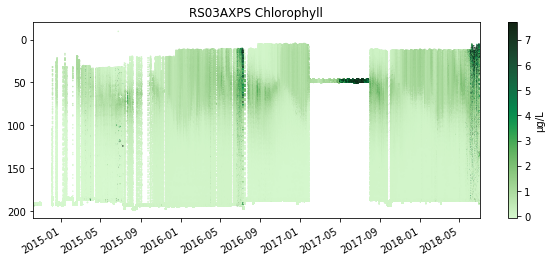

In [26]:
# Chlorophyll
make_plot(flo_data.index,flo_data.int_ctd_pressure,flo_data.fluorometric_chlorophyll_a2,cmocean.cm.algae,'µg/L','RS03AXPS Chlorophyll')


In [27]:
# Load CO2 Data
co2_list = get_dataset_list(rs03_co2_url,'ctdpf')
var_list = ['int_ctd_pressure','pco2_seawater']
co2_data = process_files(co2_list,var_list,'RS03-CO2')


Downsampling file 1 of 4
Downsampling file 2 of 4
Downsampling file 3 of 4
Downsampling file 4 of 4
Complete!


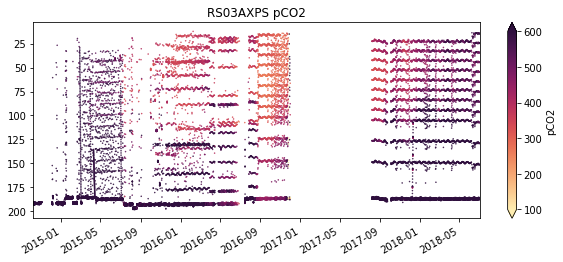

In [28]:
# pCO2
make_plot(co2_data.index,co2_data.int_ctd_pressure,co2_data.pco2_seawater,cmocean.cm.matter,'pCO2','RS03AXPS pCO2')


## CE04OSPS Oregon Offshore Cabled Shallow Profiler Mooring (588m) 

In [0]:
# Data Requests
# request_data('CE04OSPS-SF01B-2A-CTDPFA107','streamed','ctdpf_sbe43_sample','','')
# request_data('CE04OSPS-SF01B-3A-FLORTD104','streamed','flort_d_data_record','','')
# request_data('CE04OSPS-SF01B-4F-PCO2WA102','streamed','pco2w_a_sami_data_record','','')

In [0]:
ce04_ctd_url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20190507T170237-CE04OSPS-SF01B-2A-CTDPFA107-streamed-ctdpf_sbe43_sample/catalog.html'
ce04_flo_url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20190508T030633-CE04OSPS-SF01B-3A-FLORTD104-streamed-flort_d_data_record/catalog.html'
ce04_co2_url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20190508T030643-CE04OSPS-SF01B-4F-PCO2WA102-streamed-pco2w_a_sami_data_record/catalog.html'


In [31]:
# Load CTD Data
ctd_list = get_dataset_list(ce04_ctd_url)
var_list = ['practical_salinity','seawater_temperature','seawater_pressure','corrected_dissolved_oxygen']
ctd_data = process_files(ctd_list,var_list,'CE04-CTD')
# Remove outliers
ctd_data['practical_salinity2'] = ctd_data['practical_salinity'].where(reject_outliers(ctd_data['practical_salinity']))


Downsampling file 1 of 27
Downsampling file 2 of 27
Downsampling file 3 of 27
Downsampling file 4 of 27
Downsampling file 5 of 27
Downsampling file 6 of 27
Downsampling file 7 of 27
Downsampling file 8 of 27
Downsampling file 9 of 27
Downsampling file 10 of 27
Downsampling file 11 of 27
Downsampling file 12 of 27
Downsampling file 13 of 27
Downsampling file 14 of 27
Downsampling file 15 of 27
Downsampling file 16 of 27
Downsampling file 17 of 27
Downsampling file 18 of 27
Downsampling file 19 of 27
Downsampling file 20 of 27
Downsampling file 21 of 27
Downsampling file 22 of 27
Downsampling file 23 of 27
Downsampling file 24 of 27
Downsampling file 25 of 27
Downsampling file 26 of 27
Downsampling file 27 of 27
Complete!


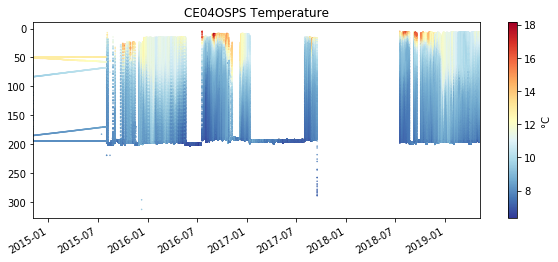

In [32]:
# Temperature
make_plot(ctd_data.index,ctd_data.seawater_pressure,ctd_data.seawater_temperature,'RdYlBu_r','°C','CE04OSPS Temperature')


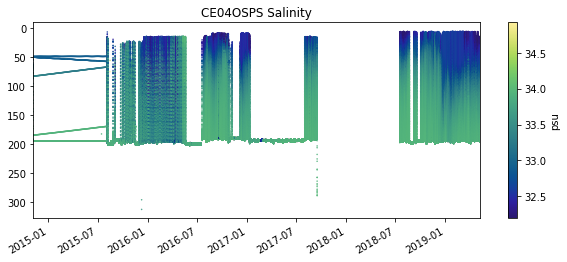

In [33]:
# Salinity
make_plot(ctd_data.index,ctd_data.seawater_pressure,ctd_data.practical_salinity2,cmocean.cm.haline,'psu','CE04OSPS Salinity')


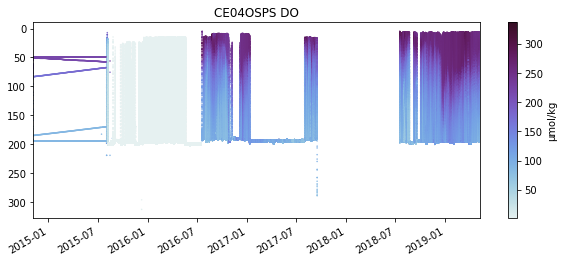

In [34]:
# DO
make_plot(ctd_data.index,ctd_data.seawater_pressure,ctd_data.corrected_dissolved_oxygen,cmocean.cm.dense,'µmol/kg','CE04OSPS DO') 


In [35]:
# Load Fluorometer Data
flo_list = get_dataset_list(ce04_flo_url,'ctdpf')
var_list = ['int_ctd_pressure','fluorometric_chlorophyll_a']
flo_data = process_files(flo_list,var_list,'CE04-FLO')
# Remove outliers
flo_data['fluorometric_chlorophyll_a2'] = flo_data['fluorometric_chlorophyll_a'].where(reject_outliers(flo_data['fluorometric_chlorophyll_a']))


Downsampling file 1 of 14
Downsampling file 2 of 14
Downsampling file 3 of 14
Downsampling file 4 of 14
Downsampling file 5 of 14
Downsampling file 6 of 14
Downsampling file 7 of 14
Downsampling file 8 of 14
Downsampling file 9 of 14
Downsampling file 10 of 14
Downsampling file 11 of 14
Downsampling file 12 of 14
Downsampling file 13 of 14
Downsampling file 14 of 14
Complete!


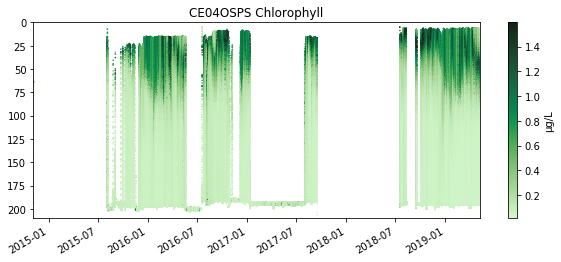

In [41]:
# Chlorophyll
make_plot(flo_data.index,flo_data.int_ctd_pressure,flo_data.fluorometric_chlorophyll_a2,cmocean.cm.algae,'µg/L','CE04OSPS Chlorophyll')
plt.ylim(210,0);
plt.savefig("%s.png" % 'CE04OSPS Chlorophyll')

In [37]:
# Load CO2 Data
co2_list = get_dataset_list(ce04_co2_url,'ctdpf')
var_list = ['int_ctd_pressure','pco2_seawater']
co2_data = process_files(co2_list,var_list,'CE04-CO2')


Downsampling file 1 of 4
Downsampling file 2 of 4
Downsampling file 3 of 4
Downsampling file 4 of 4
Complete!


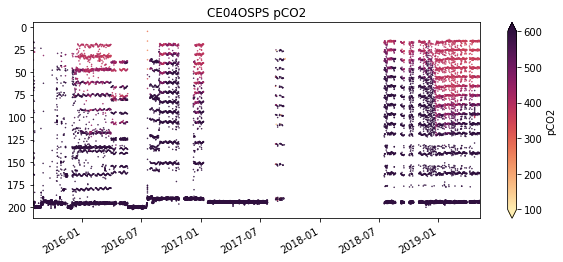

In [38]:
# pCO2
make_plot(co2_data.index,co2_data.int_ctd_pressure,co2_data.pco2_seawater,cmocean.cm.matter,'pCO2','CE04OSPS pCO2')


## GI05MOAS-PG528-03-FLORTM000

In [0]:
# Data Requests
# request_data('GI05MOAS-PG528-01-CTDGVM000','recovered_host','ctdgv_m_glider_instrument_recovered','','')
# request_data('GI05MOAS-PG528-02-DOSTAM000','recovered_host','dosta_abcdjm_glider_recovered','','')
# request_data('GI05MOAS-PG528-03-FLORTM000','recovered_host','flort_m_sample','','')

In [0]:
gl528_ctd_url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20190509T152234-GI05MOAS-PG528-01-CTDGVM000-recovered_host-ctdgv_m_glider_instrument_recovered/catalog.html'
gl528_do_url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20190509T152634-GI05MOAS-PG528-02-DOSTAM000-recovered_host-dosta_abcdjm_glider_recovered/catalog.html'
gl528_flo_url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20190509T152241-GI05MOAS-PG528-03-FLORTM000-recovered_host-flort_m_sample/catalog.html'

In [117]:
ctd_list = get_dataset_list(gl528_do_url,'ctdgv')
var_list = ['int_ctd_pressure','sci_water_temp','practical_salinity','sci_oxy4_oxygen']
ctd_data = process_files(ctd_list,var_list,'GI528-CTD')

flo_list = get_dataset_list(gl528_flo_url,'ctdgv')
var_list = ['int_ctd_pressure','sci_flbbcd_chlor_units']
flo_data = process_files(flo_list,var_list,'GI528-FLO')

# Remove outliers
ctd_data = ctd_data.where(ctd_data.int_ctd_pressure<250)
ctd_data = ctd_data.where(ctd_data.practical_salinity>0)
ctd_data['practical_salinity'] = ctd_data['practical_salinity'].where(reject_outliers(ctd_data['practical_salinity']))
ctd_data['sci_oxy4_oxygen'] = ctd_data['sci_oxy4_oxygen'].where(reject_outliers(ctd_data['sci_oxy4_oxygen']))

flo_data = flo_data.where(flo_data.int_ctd_pressure<250)
flo_data['sci_flbbcd_chlor_units'] = flo_data['sci_flbbcd_chlor_units'].where(flo_data['sci_flbbcd_chlor_units']<5)


Downsampling file 1 of 1
Complete!
Downsampling file 1 of 1
Complete!


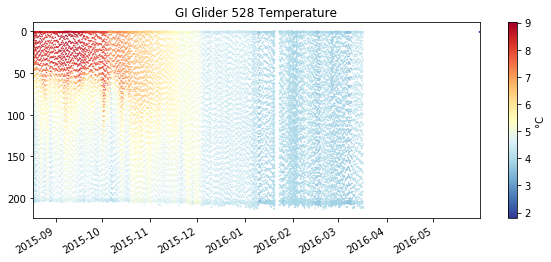

In [118]:
# Temperature
make_plot(ctd_data.index,ctd_data.int_ctd_pressure,ctd_data.sci_water_temp,'RdYlBu_r','°C','GI Glider 528 Temperature')


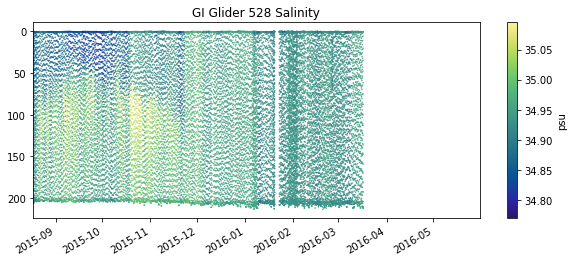

In [119]:
# Salinity
make_plot(ctd_data.index,ctd_data.int_ctd_pressure,ctd_data.practical_salinity,cmocean.cm.haline,'psu','GI Glider 528 Salinity')


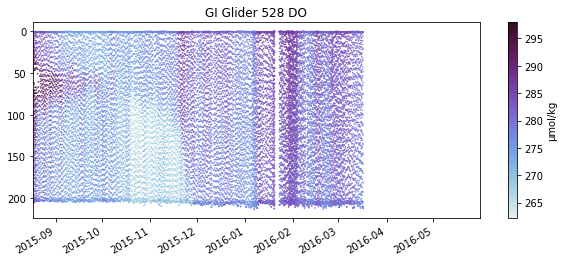

In [120]:
# DO
make_plot(ctd_data.index,ctd_data.int_ctd_pressure,ctd_data.sci_oxy4_oxygen,cmocean.cm.dense,'µmol/kg','GI Glider 528 DO') 


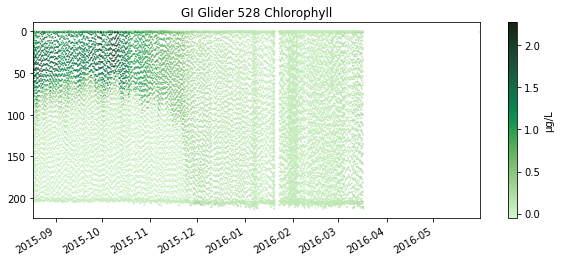

In [121]:
# Chlorophyll
make_plot(flo_data.index,flo_data.int_ctd_pressure,flo_data.sci_flbbcd_chlor_units,cmocean.cm.algae,'µg/L','GI Glider 528 Chlorophyll')
